GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Usando acelerador: auto
Grid Search: 1 combinações


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[1] Params: 256, LR: 0.001 | MAE Holdout: 5.2987
--> Melhores Params: {'hidden_size': 256, 'dropout': 0.15, 'num_layers': 2, 'lr': 0.001, 'input_chunk': 26, 'output_chunk': 4, 'n_epochs': 30, 'batch_size': 16} | MAE=5.2987
Iniciando Walk-Forward (isso pode demorar)...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
H

   horizon       MAE      MASE
0        1  2.445045  0.692408
1        2  2.460012  0.702539
2        3  2.692262  0.765123
3        4  2.498156  0.715288


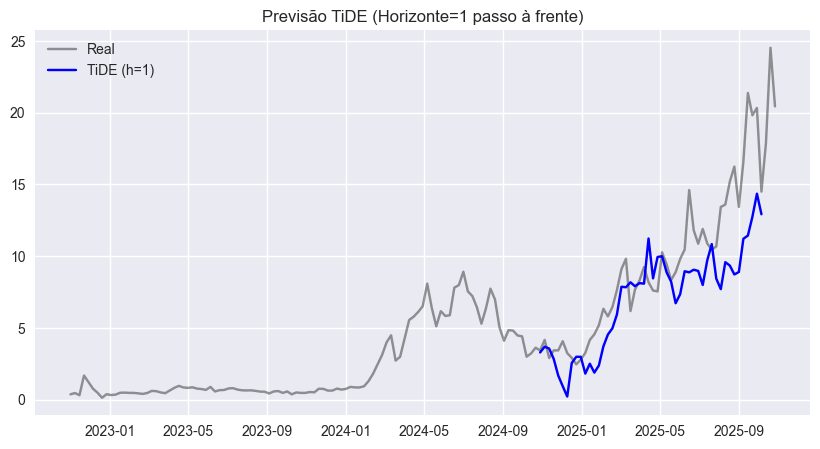

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch

from darts import TimeSeries
from darts.models import TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore")

HORIZON = 4
INITIAL_TRAIN = 104
SEASONALITY = 52
TEST_SIZE = 30
RANDOM_STATE = 42

accelerator = "auto" 
print(f"Usando acelerador: {accelerator}")

df = pd.read_csv("data_updated.csv")
df["week"] = pd.to_datetime(df["week"])
df = df.sort_values("week").set_index("week")
df[["volume", "inv", "users"]] = df[["volume", "inv", "users"]].astype(np.float32)

ts_full = TimeSeries.from_dataframe(df, value_cols="volume", freq="W-MON")

cov_dt = datetime_attribute_timeseries(ts_full, attribute="month", one_hot=True)
cov_dt = cov_dt.stack(datetime_attribute_timeseries(ts_full, attribute="week", one_hot=False))
cov_ext = TimeSeries.from_dataframe(df, value_cols=["inv", "users"], freq="W-MON")
covariates = cov_dt.stack(cov_ext).astype(np.float32)

train_end_idx = len(ts_full) - TEST_SIZE
ts_train_val = ts_full[:train_end_idx] 
ts_holdout = ts_full[train_end_idx:]   

def calculate_mase(y_true, y_pred, y_train, m=SEASONALITY):

    naive_errors = np.abs(y_train[m:] - y_train[:-m])
    mae_naive = np.mean(naive_errors)
    if mae_naive < 1e-6 or np.isnan(mae_naive):
        return np.nan
    return np.mean(np.abs(y_true - y_pred)) / mae_naive

def build_model(params):
    
    my_stopper = EarlyStopping(
        monitor="train_loss",
        patience=5,
        min_delta=0.001,
        mode='min',
    )
    
    return TiDEModel(
        input_chunk_length=params["input_chunk"],
        output_chunk_length=params["output_chunk"],
        hidden_size=params["hidden_size"],
        num_encoder_layers=params["num_layers"],
        num_decoder_layers=params["num_layers"],
        dropout=params["dropout"],
        batch_size=params["batch_size"],
        n_epochs=params["n_epochs"],
        optimizer_kwargs={"lr": params["lr"]},
        random_state=RANDOM_STATE,
        pl_trainer_kwargs={
            "accelerator": accelerator, 
            "callbacks": [my_stopper],
            "enable_progress_bar": False
        }
    )

param_grid = {
    "hidden_size": [256], 
    "dropout": [0.15],
    "num_layers": [2],
    "lr": [1e-3],
    "input_chunk": [26], 
    "output_chunk": [HORIZON], 
    "n_epochs": [30], 
    "batch_size": [16],
}

keys, values = zip(*param_grid.items())
grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_params = None
best_score = np.inf

print(f"Grid Search: {len(grid)} combinações")

scaler_y = Scaler()
scaler_cov = Scaler()

y_train_scaled = scaler_y.fit_transform(ts_train_val)
cov_scaled = scaler_cov.fit_transform(covariates[:train_end_idx]) 
cov_full_scaled = scaler_cov.transform(covariates) 

for i, params in enumerate(grid, start=1):
    model = build_model(params)
    
    model.fit(
        series=y_train_scaled, 
        past_covariates=cov_full_scaled, 
        verbose=False
    )
    

    pred_scaled = model.predict(n=len(ts_holdout), past_covariates=cov_full_scaled)
    pred = scaler_y.inverse_transform(pred_scaled)
    
    mae = np.mean(np.abs(ts_holdout.values() - pred.values()))
    
    print(f"[{i}] Params: {params['hidden_size']}, LR: {params['lr']} | MAE Holdout: {mae:.4f}")
    
    if mae < best_score:
        best_score = mae
        best_params = params

print(f"--> Melhores Params: {best_params} | MAE={best_score:.4f}")


def run_walk_forward(params):
    records = []
    
    t_scaler = Scaler()
    c_scaler = Scaler()
    

    for cutoff in range(INITIAL_TRAIN, len(ts_full) - HORIZON + 1):

        train_series = ts_full[:cutoff]
        target_series = ts_full[cutoff : cutoff + HORIZON]
        

        t_s = t_scaler.fit_transform(train_series)
        c_s = c_scaler.fit_transform(covariates)
        
        model = build_model(params)
        model.fit(series=t_s, past_covariates=c_s, verbose=False)
        
        p_s = model.predict(n=HORIZON, past_covariates=c_s)
        p_inverse = t_scaler.inverse_transform(p_s)
        
        truth = target_series.values().flatten()
        pred = p_inverse.values().flatten()
        train_vals = train_series.values().flatten()
        
        current_date = train_series.end_time()
        
        for h in range(HORIZON):
            mase = calculate_mase(truth[h], pred[h], train_vals, m=SEASONALITY)
            records.append({
                "cutoff": current_date,
                "horizon": h + 1,
                "y_true": truth[h],
                "y_pred": pred[h],
                "abs_error": abs(truth[h] - pred[h]),
                "mase": mase
            })
            
    return pd.DataFrame(records)

print("Iniciando Walk-Forward (isso pode demorar)...")
df_res = run_walk_forward(best_params)

metrics = df_res.groupby("horizon").agg(
    MAE=("abs_error", "mean"),
    MASE=("mase", "mean")
).reset_index()

print(metrics)

fig, ax = plt.subplots(figsize=(10, 5))
h1_data = df_res[df_res["horizon"] == 1]
ax.plot(ts_full.time_index, ts_full.values(), label="Real", color="black", alpha=0.4)
ax.plot(h1_data["cutoff"] + pd.Timedelta(weeks=1), h1_data["y_pred"], label="TiDE (h=1)", color="blue")
ax.set_title("Previsão TiDE (Horizonte=1 passo à frente)")
ax.legend()
plt.show()